### Fig. 3 | Forecasting the spreading and recovery of chronic pain. ###
We run the analyses for both the model representation and model evaluation.

A. Stability and Longitudinal Chronic Pain Spreading

1. Stability of Chronic Pain Sites
2. Co-occurence Heatmap for Odds Ratios
3. Association Between Sistance and Log-Odds Ratios

B. Examining the risk score longitudinally

1. Plotting the risk score across baseline and follow-up (prior and after controlling for baseline pain sites)
2. Adjusted Risk Score across level of Changes in Number of Pain Sites 

C. Examining categories and biological markers longitudinally

1. Effect Sizes across Levels of Spreading
2. Adjusted Categories and Markers Longitudinally
3. Change in Chronic Pain Sites across Spreading (descriptive)

In [4]:
#### Import Libraries ####
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn import linear_model, metrics
from pySankey.sankey import sankey
import matplotlib.pyplot as plt
import nltools
import math
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
plt.rcParams['font.size'] = 8
sns.set(font="Arial", style = 'white')
fs = 8 #fontsize
Folder = '/Volumes/HD/Script_folder/'

def cohen_d(x,y): #Cohen_d with pooled standard deviation
        return (np.mean(x) - np.mean(y)) / math.sqrt(((x.shape[0] - 1) * np.std(x, ddof=1) + (y.shape[0] - 1) * np.std(y, ddof=1)) / (x.shape[0] + y.shape[0] - 2))


In [5]:
# Loading all data
variables, W = pd.read_csv(Folder + '0_Variables_V3.csv'), pd.read_csv(Folder + 'Coefficients_PLSReg_3comp.csv')
variables = variables[variables.coding_finished==1]
variables_T0, variables_T2 = list((variables['Name'] + '_' + variables['T0']).values), list((variables['Name'] + '_' + variables['T2']).values) #List of variables to select
variables['weights'] = W.Coefficients.values

# Computing the risk score
preproc_UKB_Test, preproc_UKB_FollowUp = pd.read_csv(Folder + '5_TestData_PreprocFeatures_Adv.csv'), pd.read_csv(Folder + '6_BrainVisit_PreprocFeatures_Adv.csv')
preproc_UKB_Test['PLS'], preproc_UKB_FollowUp['PLS'] = np.dot(preproc_UKB_Test[variables_T0], variables['weights']), np.dot(preproc_UKB_FollowUp[variables_T2], variables['weights'])

In [6]:
# Matching eid
list_eid = np.intersect1d(preproc_UKB_Test.eid, preproc_UKB_FollowUp.eid)
UKB_T2 = preproc_UKB_Test[preproc_UKB_Test.eid.isin(list_eid)].sort_values(by = 'eid').reset_index(drop=True)
UKB_B = preproc_UKB_FollowUp[preproc_UKB_FollowUp.eid.isin(list_eid)].sort_values(by = 'eid').reset_index(drop=True)

In [7]:
# Create Number of Chronic Pain Sites as 4 sites or more, including widespread pain
UKB_T2['NCPS_T0'], UKB_B['NCPS_T2'] = np.where((UKB_T2.NumberChronicPainTypes_T0 > 4) | (UKB_T2.ChronicWidespreadPain_T0 == 1), 4, UKB_T2.NumberChronicPainTypes_T0), np.where((UKB_B.NumberChronicPainTypes_T2 > 4) | (UKB_B.ChronicWidespreadPain_T2 == 1), 4, UKB_B.NumberChronicPainTypes_T2)

# Obtain sample size for each spreading level
UKB_T2['one'], UKB_B['one'] = 1,1
labels = ['0', '1', '2', '3', '4+']
labels_B = [labels[idx] + ' (' + f"{i:,}" + ')' for idx, i in enumerate(UKB_B.groupby(by = 'NCPS_T2')['one'].count().values)]
labels_T2 = [labels[idx] + ' (' + f"{i:,}" + ')' for idx, i in enumerate(UKB_T2.groupby(by = 'NCPS_T0')['one'].count().values)]
print('Initial Visit:', labels_B)
print('Follow-Up Visit:', labels_T2)

Initial Visit: ['0 (30,308)', '1 (10,541)', '2 (4,145)', '3 (1,584)', '4+ (1,130)']
Follow-Up Visit: ['0 (29,593)', '1 (10,678)', '2 (4,435)', '3 (1,757)', '4+ (1,245)']


In [8]:
#Renaming columns for visualization
UKB_T2['Chronic Pain Sites'], UKB_B['Chronic Pain Sites'] = UKB_T2.NCPS_T0.replace(dict(zip(np.arange(0,5), labels_T2))), UKB_B.NCPS_T2.replace(dict(zip(np.arange(0,5), labels_B)))

# Compute color dictionnary
dico_sankey = dict(zip(labels_T2, [mpl.colors.to_hex(c) for c in sns.color_palette('rocket_r', 5)]))
dico_sankey.update(dict(zip(labels_B, [mpl.colors.to_hex(c) for c in sns.color_palette('rocket_r', 5)])))

Test-Retest Explained Variance (%): 0.2055491733757219


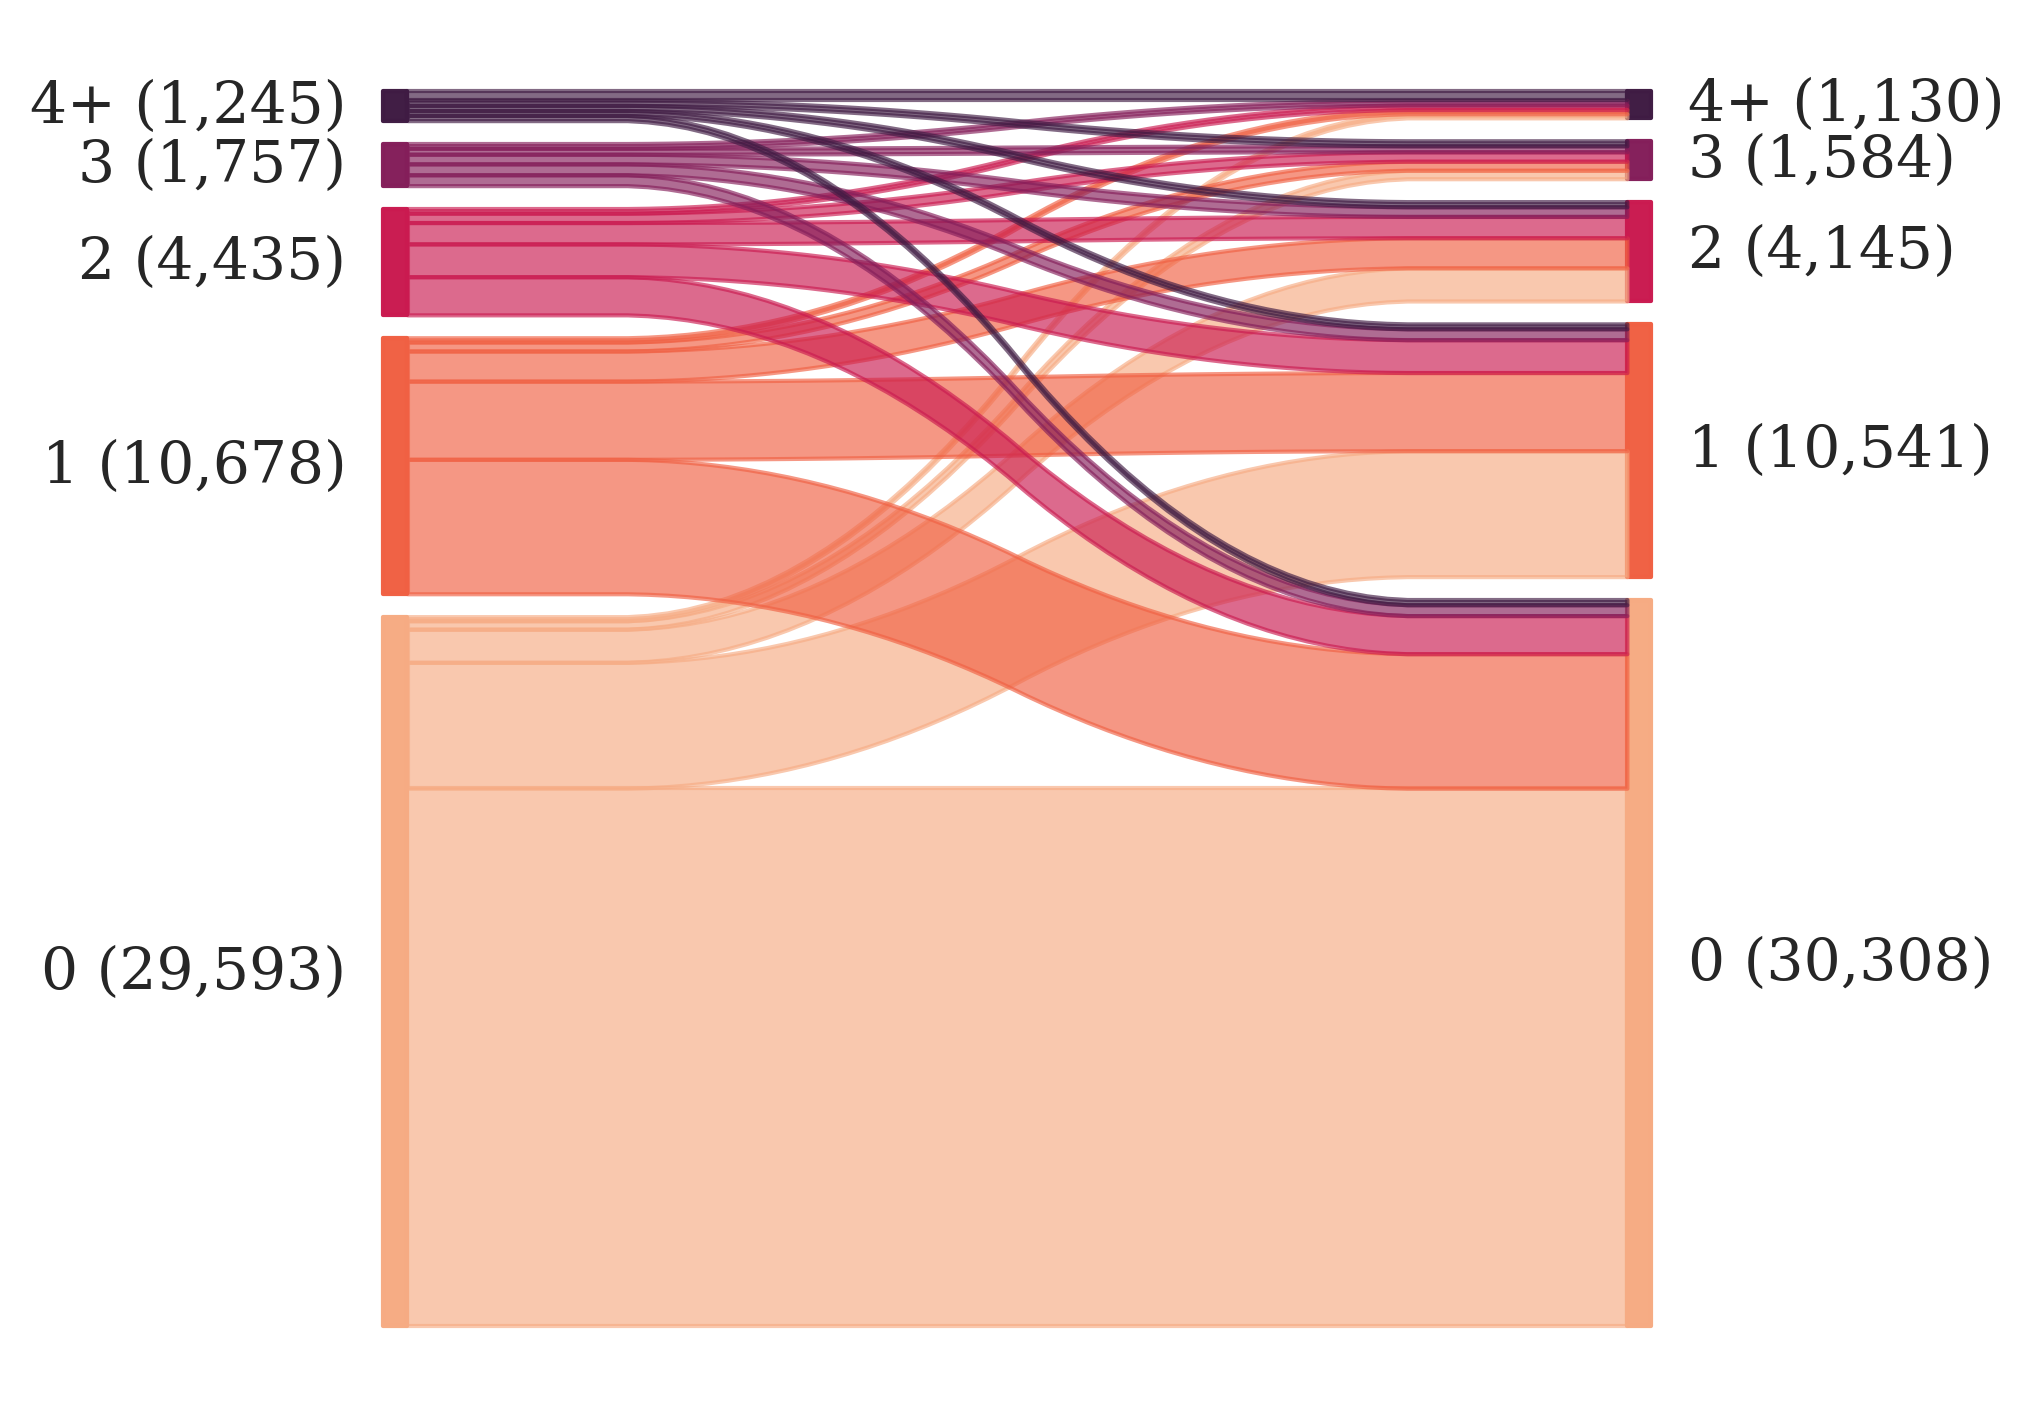

In [9]:
#### FIGURE A.1. Stability of Chronic Pain Sites ####
sankey(left = UKB_T2['Chronic Pain Sites'], right = UKB_B['Chronic Pain Sites'], colorDict=dico_sankey)
print('Test-Retest Explained Variance (%):', UKB_T2.NCPS_T0.corr(UKB_B.NCPS_T2)**2)
plt.rcParams['font.size'] = 8
sns.set(font="Arial", style = 'white')

In [10]:
# Pain Sites to examine
Sites1 = ['Headaches','Facial','Neck/Shoulder','Stomach/Abdo','Back','Hip','Knee'] # Long Labels
Sites2 = ['Ha', 'F', 'N/S', 'S/A', 'B', 'Hp', 'K'] #Short labels
P = ['Headaches','FacialPain','NeckShoulderPain','StomachAbdominalPain','BackPain','HipPain','KneePain']

#Filter Widespread Pain (Pain All Over) from Initial and Follow-up Visits (can't estimate their occurence)
F_WP = (UKB_T2.WidespreadPainLastMonth_T0!=1) & (UKB_B.WidespreadPainLastMonth_T2!=1)

In [11]:
# Examine risk based on pain occurence and risk based on risk score given pain occurence through Odds Ratios 
clf = linear_model.LogisticRegression(penalty='none')
CP_array, CP_array_risk, D_array, D = np.zeros((7,7)), np.zeros((7,7)), np.zeros((7,7)), np.arange(7) 
# Note that the sites are ordered from top to bottom, as a result, distance computed as their distance from their ranks
for i in range(7): # For loop
    for j in range(7):
        D_array[j, i] = abs(D[i] - D[j]) #Taking absolute distance #i = T0, j = T2

        CP_i, CP_j = 'Chronic' + P[i] + '_T0', 'Chronic' + P[j] + '_T2'
        clf.fit(UKB_T2[F_WP][[CP_i]], UKB_B[F_WP][CP_j])
        CP_array[j, i] = clf.coef_[0][0] # (Betas, i.e. log odds) are append
        
        CP_F = UKB_T2[F_WP][CP_i]==1 #Filter to select those with a given chronic pain site.
        clf.fit(UKB_T2[F_WP][CP_F][['PLS']], UKB_B[F_WP][CP_F][CP_j])
        CP_array_risk[j, i] = clf.coef_[0][0]   


# Clean up the matrices by labeling them and exponential function to obtain odds ratio
idx, col = pd.Series([i + ' <' for i in Sites2], name = 'Follow-Up'), pd.Series([i + ' >' for i in Sites2], name = 'Baseline')
CP_OR, CP_Risk_OR = pd.DataFrame(data=np.exp(CP_array), index = idx, columns = col), pd.DataFrame(data=np.exp(CP_array_risk), index = idx, columns = col)
print(CP_OR, '\n', CP_Risk_OR)


Baseline        Ha >        F >     N/S >      S/A >       B >      Hp >  \
Follow-Up                                                                  
Ha <       19.459729   7.859236  2.972200   3.336060  2.073087  2.140079   
F <         6.227900  67.765149  4.343813   6.451285  2.400159  3.999684   
N/S <       2.473325   3.628529  5.123821   3.073326  2.947072  2.997536   
S/A <       3.038870   4.948222  2.891535  12.792972  2.600810  2.625664   
B <         2.029192   2.649583  2.912934   2.688932  6.694216  3.402851   
Hp <        1.947630   2.818344  2.572304   2.242766  2.694167  7.279227   
K <         1.566484   1.892562  2.005378   2.118448  2.124993  2.537064   

Baseline        K >  
Follow-Up            
Ha <       1.590302  
F <        2.103212  
N/S <      2.122788  
S/A <      2.027822  
B <        2.215973  
Hp <       2.283490  
K <        5.502528   
 Baseline       Ha >       F >     N/S >     S/A >       B >      Hp >  \
Follow-Up                                 

<AxesSubplot:xlabel='Baseline', ylabel='Follow-Up'>

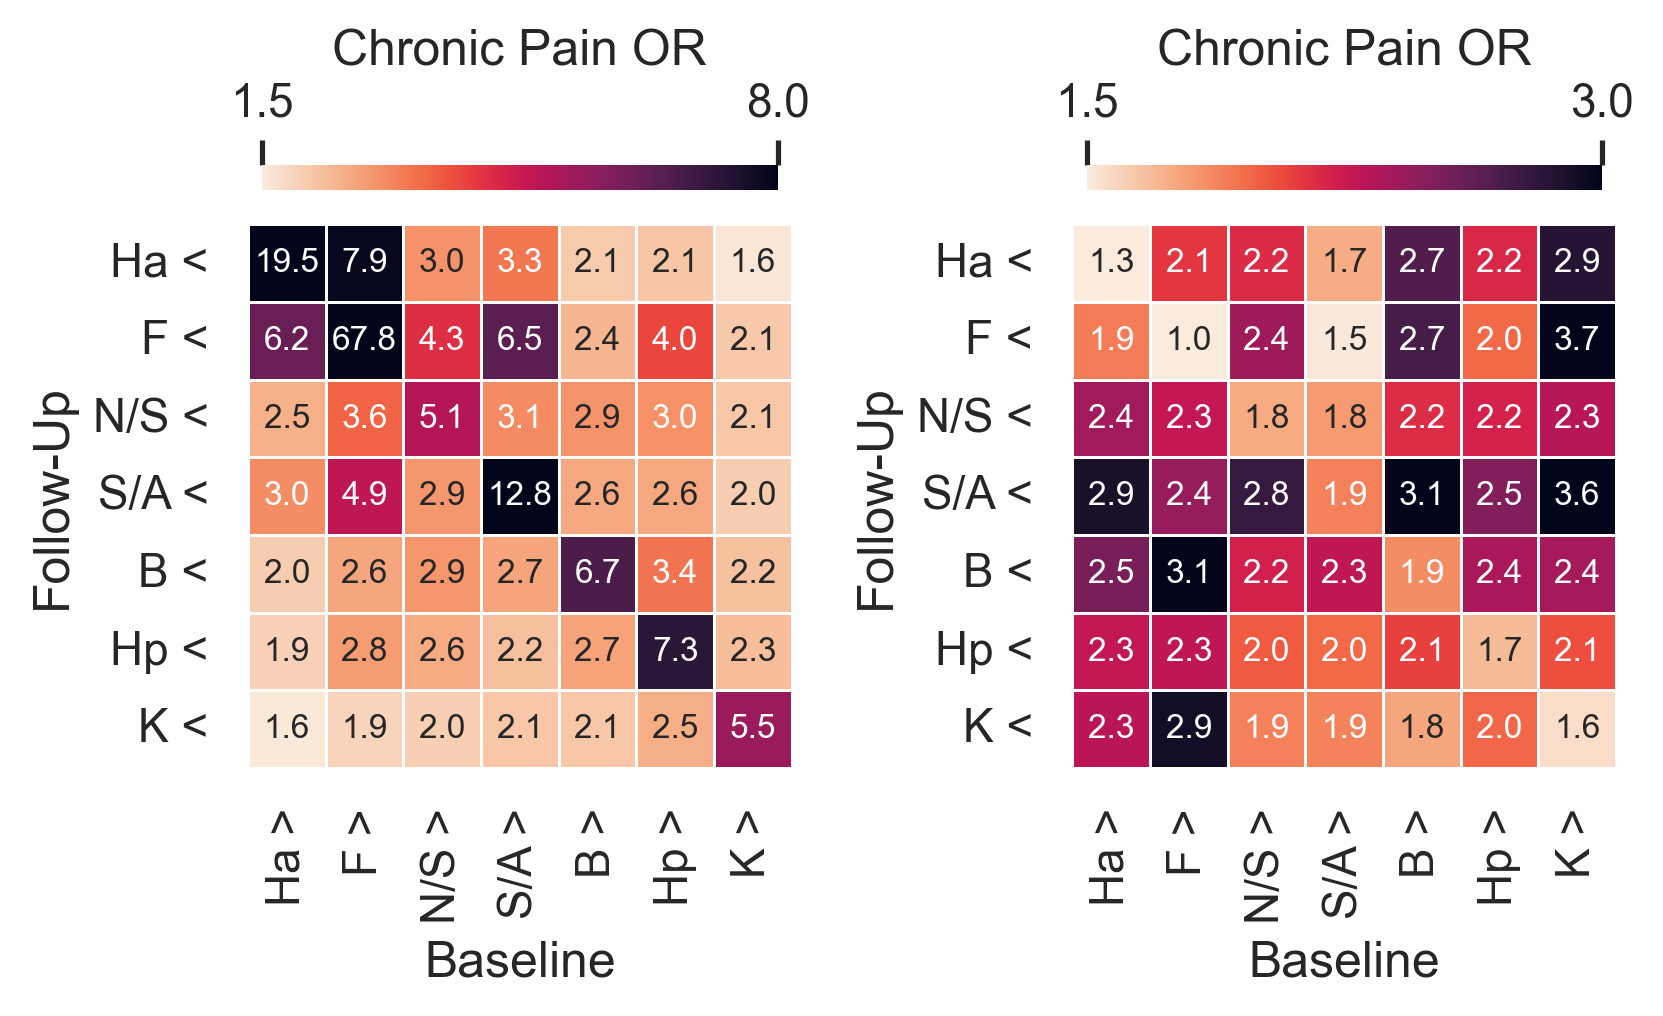

In [12]:
#### Figure A2. Co-occurence Heatmap for Odds Ratios ####
fig, axs = plt.subplots(ncols=2, nrows=1,  figsize=(6.5, 3))
sns.heatmap(ax = axs[0], data=CP_OR, fmt='.1f', cmap='rocket_r', square=True, vmin=1.5, vmax=8, linewidths=0.25, annot=True, annot_kws={"fontsize": 8}, cbar = True, cbar_kws =  {'label':'Chronic Pain OR','ticks':np.asarray([1.5,8]), 'shrink':.75, 'use_gridspec':False, 'location':'top'})
sns.heatmap(ax = axs[1], data=CP_Risk_OR, fmt='.1f', cmap='rocket_r', square=True, vmin=1.5, vmax=3, linewidths=0.25, annot=True, annot_kws={"fontsize": 8}, cbar = True, cbar_kws =  {'label':'Chronic Pain OR','ticks':np.asarray([1.5,3]), 'shrink':.75, 'use_gridspec':False, 'location':'top'})

In [13]:
# Vectorize the matrices (use the original values that are not np.exp())
CP_vec, CP_vec_risk, D_vec = np.asarray(CP_array).flatten(), np.asarray(CP_array_risk).flatten(), np.asarray(D_array).flatten()

# Permutation the associations between matrices and distances
CP_perm = nltools.stats.correlation_permutation(D_vec, CP_vec, method='permute', n_permute=10000, metric='pearson', tail=2, return_perms=False, random_state=0) 
CP_perm_risk = nltools.stats.correlation_permutation(D_vec, CP_vec_risk, method='permute', n_permute=10000, metric='pearson', tail=2, return_perms=False, random_state=0) 
print('Distance and Pain Occurence OR Correlation:', CP_perm['correlation']**2, ', permutated p-value:', CP_perm['p'])
print('Distance and Risk given Pain Occurence OR Correlation:', CP_perm_risk['correlation']**2, ', permutated p-value:', CP_perm_risk['p'])

Distance and Pain Occurence OR Correlation: 0.4105662339447054 , permutated p-value: 9.999000099990002e-05
Distance and Risk given Pain Occurence OR Correlation: 0.2496329070919084 , permutated p-value: 9.999000099990002e-05


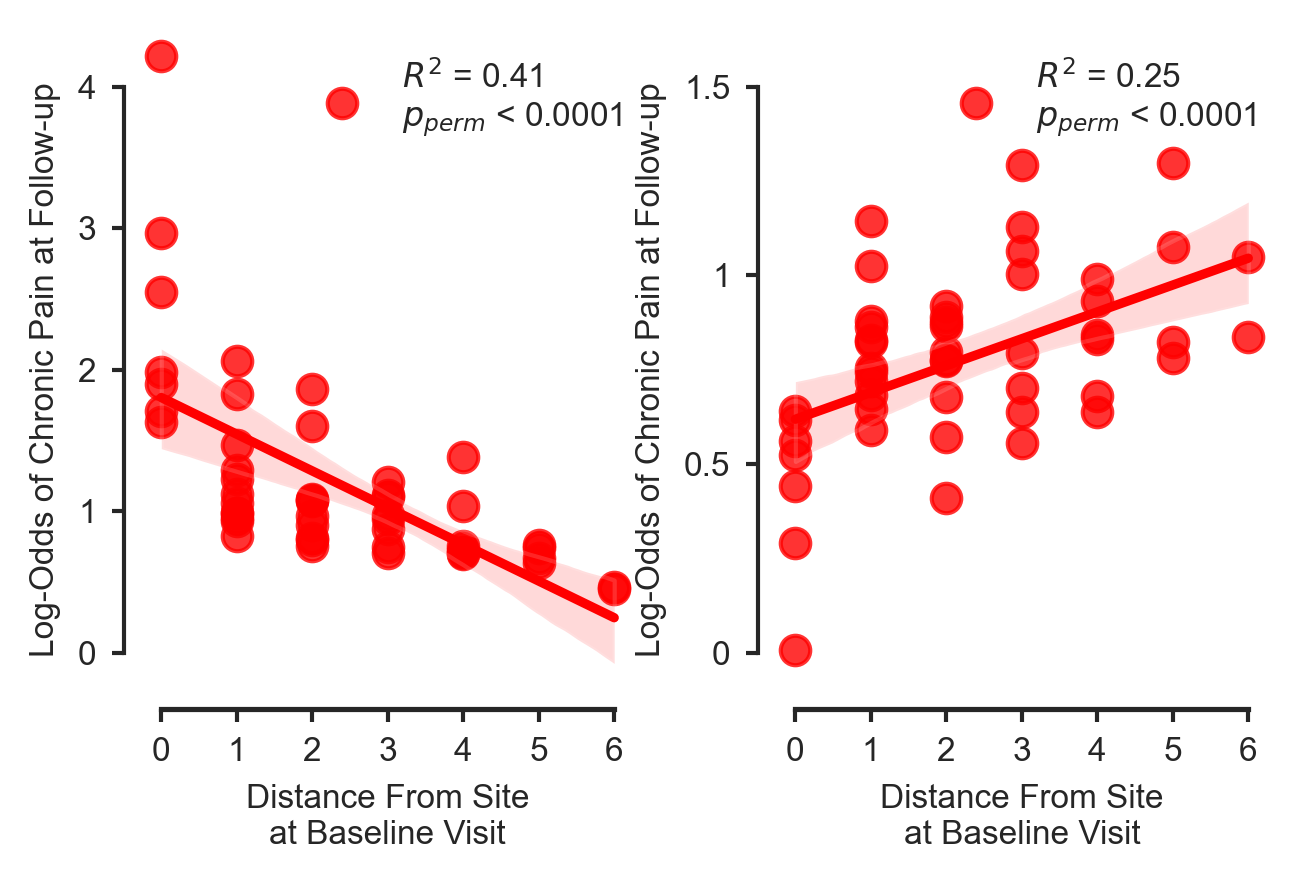

In [14]:
#### Figure A3. Association Between Sistance and Log-Odds Ratios ####
fig, axs = plt.subplots(ncols=2, nrows=1,  figsize=(5, 3))
sns.regplot(ax = axs[0], x = D_vec, y = CP_vec, color = 'Red', scatter_kws={'s':50}, label = "$R^2$ = 0.41\n$p$$_{perm}$ < 0.0001")
axs[0].set_ylim(-0.4, 4.4), axs[0].set_yticks(np.arange(5))
axs[0].set_yticklabels([0, 1, 2, 3, 4], fontsize = 8), axs[0].spines['left'].set_bounds((0, 4))
sns.regplot(ax = axs[1], x = D_vec, y = CP_vec_risk, color = 'Red', scatter_kws={'s':50}, label = "$R^2$ = 0.25\n$p$$_{perm}$ < 0.0001")
axs[1].set_ylim(-0.15, 1.65), axs[1].set_yticks(np.arange(0, 2, 0.5))
axs[1].set_yticklabels([0, 0.5, 1, 1.5], fontsize = 8), axs[1].spines['left'].set_bounds((0, 1.5))
for i in range(2):
    axs[i].set_xlim(-0.5, 6.5), axs[i].set_xticks(np.arange(0,7,1)) # Share same x-axis
    axs[i].set_xticklabels(np.arange(0,7,1), fontsize = 8), axs[i].spines['bottom'].set_bounds((0, 6))
    axs[i].set_xlabel('Distance From Site\nat Baseline Visit', fontsize = 8)
    axs[i].set_ylabel('Log-Odds of Chronic Pain at Follow-up', fontsize = 8)
    axs[i].spines[['top', 'right']].set_visible(False) #Details of plotting
    axs[i].legend(frameon=False, fontsize = 8)
    axs[i].spines[['top', 'left']].set_linewidth(1)
    axs[i].tick_params(left=True, bottom=True, length=3, width=1)

In [15]:
# Compute residuals of the risk score after controlling for number of pain sites at baseline
UKB_B['Change_Age'], UKB_T2['Change_Age'] = (UKB_B.Age_T2 - UKB_T2.Age_T0), (UKB_B.Age_T2 - UKB_T2.Age_T0) #Change in Age
lr = linear_model.LinearRegression()
UKB_T2['NCPS2_T0'], UKB_B['NCPS2_T2'] = UKB_T2.NCPS_T0**2, UKB_B.NCPS_T2**2
reg = lr.fit(UKB_T2[['NCPS_T0', 'NCPS2_T0']], UKB_T2.PLS).predict(UKB_T2[['NCPS_T0', 'NCPS2_T0']])
UKB_B['PLS_res'], UKB_T2['PLS_res'] = stats.zscore(UKB_T2.PLS - reg), stats.zscore(UKB_T2.PLS - reg)

In [16]:
# Risk Score across Spreading (Baseline & Follow-Up)
Spread_mat, Spread_res_mat = np.zeros((5,5)), np.zeros((5,5))
for i in range(0, 5): # For loop, i = Pain at T0, j = Pain at T2
    for j in range(0, 5):
        CP_F = (UKB_T2.NCPS_T0==i) & (UKB_B.NCPS_T2==j)
        Spread_mat[j, i] = UKB_T2[CP_F].PLS.mean() #Original Score
        Spread_res_mat[j, i] = UKB_T2[CP_F].PLS_res.mean() #Residuals of Original Score
col, idx = pd.Series(data=labels, name = 'Chronic Pain Sites\nat Baseline'), pd.Series(data=labels[::-1], name = 'Chronic Pain Sites\nat Follow-Up')
CP_Spread, CP_Spread_Res = pd.DataFrame(data = Spread_mat[::-1], columns = col, index = idx), pd.DataFrame(data = Spread_res_mat[::-1], columns = col, index = idx)
print(CP_Spread, '\n', CP_Spread_Res)

Chronic Pain Sites
at Baseline           0         1         2         3  \
Chronic Pain Sites\nat Follow-Up                                           
4+                                0.155463  0.334206  0.418607  0.430288   
3                                 0.054613  0.123264  0.202953  0.291389   
2                                -0.072848  0.017280  0.112944  0.218845   
1                                -0.204882 -0.080457  0.056274  0.209283   
0                                -0.315232 -0.174190  0.003272  0.134688   

Chronic Pain Sites
at Baseline          4+  
Chronic Pain Sites\nat Follow-Up            
4+                                0.767346  
3                                 0.573536  
2                                 0.469155  
1                                 0.311825  
0                                 0.347248   
 Chronic Pain Sites
at Baseline           0         1         2         3  \
Chronic Pain Sites\nat Follow-Up                                          

<AxesSubplot:xlabel='Chronic Pain Sites\nat Baseline', ylabel='Chronic Pain Sites\nat Follow-Up'>

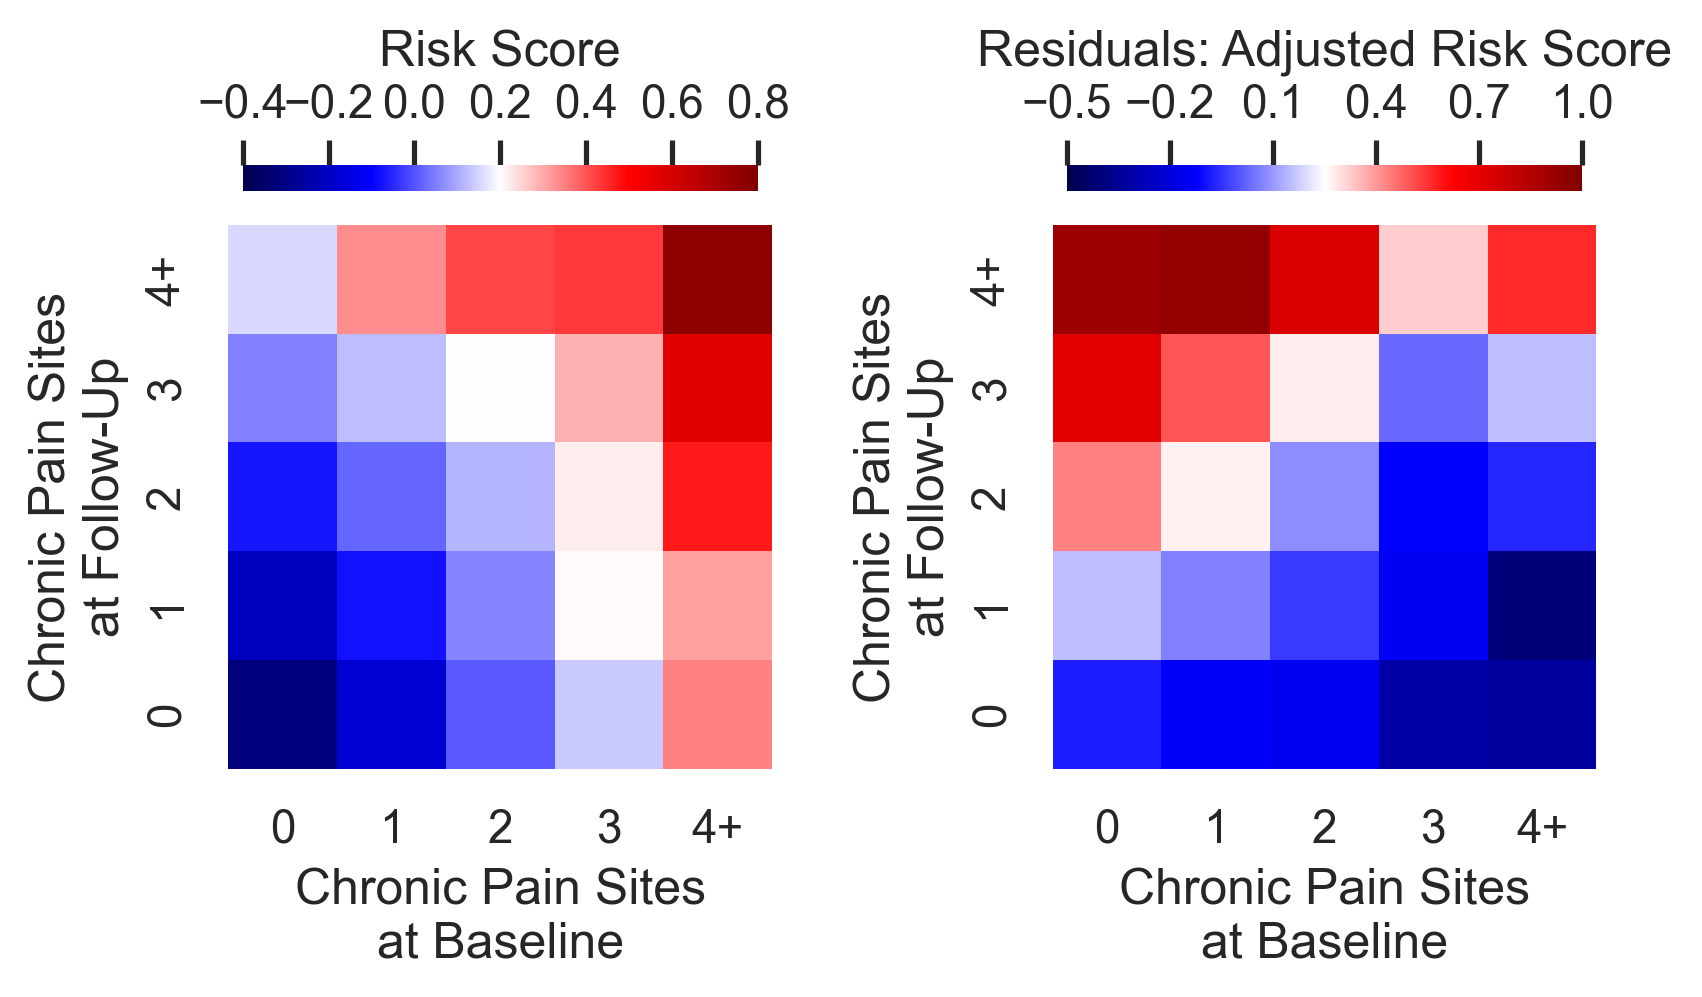

In [17]:
#### FIGURE B1. Plotting the risk score across baseline and follow-up (prior and after controlling for baseline pain sites) ####
fig, axs = plt.subplots(ncols=2, nrows=1,  figsize=(6.5, 3))
sns.heatmap(ax = axs[0], data=CP_Spread, cmap='seismic', square=True, vmin=-0.4, vmax=0.8, cbar = True, cbar_kws =  {'label':'Risk Score','ticks':np.arange(-0.4, 1, 0.2), 'shrink':.75, 'use_gridspec':False, 'location':'top'})
sns.heatmap(ax = axs[1], data=CP_Spread_Res, cmap='seismic', square=True, vmin=-0.5, vmax=1, cbar = True, cbar_kws =  {'label':'Residuals: Adjusted Risk Score','ticks':np.arange(-0.5, 1.5, 0.3), 'shrink':.75, 'use_gridspec':False, 'location':'top'})

In [18]:
# Compute the change in number of pain sites
UKB_B['ChronicSpread'], UKB_T2['ChronicSpread'] = (UKB_B.NCPS_T2 - UKB_T2.NCPS_T0), (UKB_B.NCPS_T2 - UKB_T2.NCPS_T0)
# Label for Change in Number of Pain Sites
Change = ['-4+', '-3', '-2', '-1', '0', '1', '2', '3', '4+']

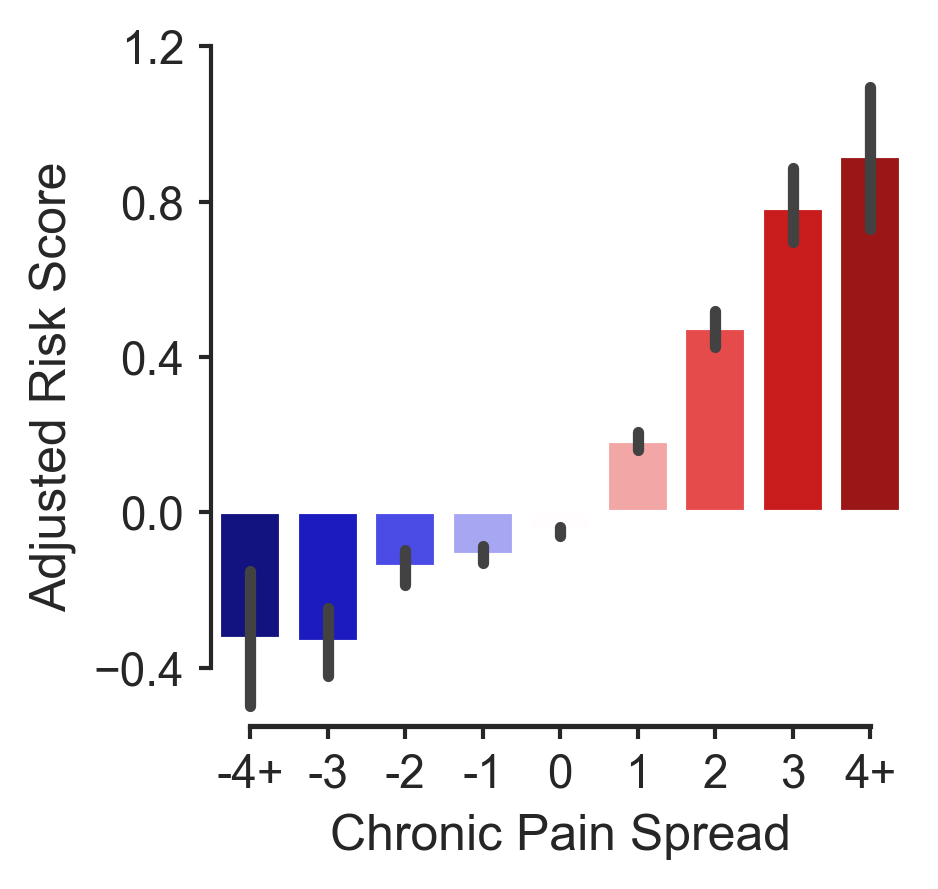

In [19]:
#### FIGURE B2. Adjusted Risk Score across Change in Number of Pain Sites ####
fig, axs = plt.subplots(ncols=1, nrows=1,  figsize=(3, 3))
sns.barplot(ax = axs, data = UKB_B, x = 'ChronicSpread', y = 'PLS_res', palette = sns.color_palette("seismic", 9))
axs.set_ylim(-0.55, 1.2), axs.set_yticks(np.arange(-0.4, 1.6, 0.4))
axs.set_xticklabels(Change)
axs.set_ylabel('Adjusted Risk Score'), axs.set_xlabel('Chronic Pain Spread')
axs.spines['bottom'].set_bounds((0, 8)), axs.spines['left'].set_bounds((-0.4, 1.2))
axs.tick_params(left=True, bottom=True, length=3, width=1), axs.spines[['top', 'right']].set_visible(False)
axs.spines[['top', 'left']].set_linewidth(1)

In [20]:
# Estimating Cohen's d + AUC-ROC between Pain-Free and those who change in number of pain sites
# Apply 10,000 boostraps
list_roc, list_cohen = [], [[], [],[]]
CPF = UKB_T2[(UKB_B.NCPS_T2==0) & (UKB_T2.NCPS_T0==0)]
CPF.insert(0, 'Group', 0)
rng = np.random.default_rng()
for s in np.arange(-4,5,1):
    TMP  = UKB_T2[UKB_T2['ChronicSpread']==s]
    TMP.insert(0, 'Group', 1)
    list_cohen[0].append(cohen_d(TMP.PLS_res, CPF.PLS_res))
    bs = stats.bootstrap((TMP.PLS_res, CPF.PLS_res), cohen_d, confidence_level=0.95,method='percentile',random_state=rng,n_resamples=10000,vectorized=False)
    list_cohen[1].append(bs.confidence_interval[0]), list_cohen[2].append(bs.confidence_interval[1])
    if s < 0: list_roc.append(metrics.roc_auc_score(y_score = CPF.append(TMP).PLS_res, y_true =  abs(CPF.append(TMP).Group-1)))
    else: list_roc.append(metrics.roc_auc_score(y_score = CPF.append(TMP).PLS_res, y_true = CPF.append(TMP).Group))
Cohen_D = pd.DataFrame(data = list_cohen, index = ['Estimate', 'Low', 'High'], columns = Change).T
AUC_ROC = pd.DataFrame(data = list_roc, columns = ['AUC-ROC'], index = Change).T

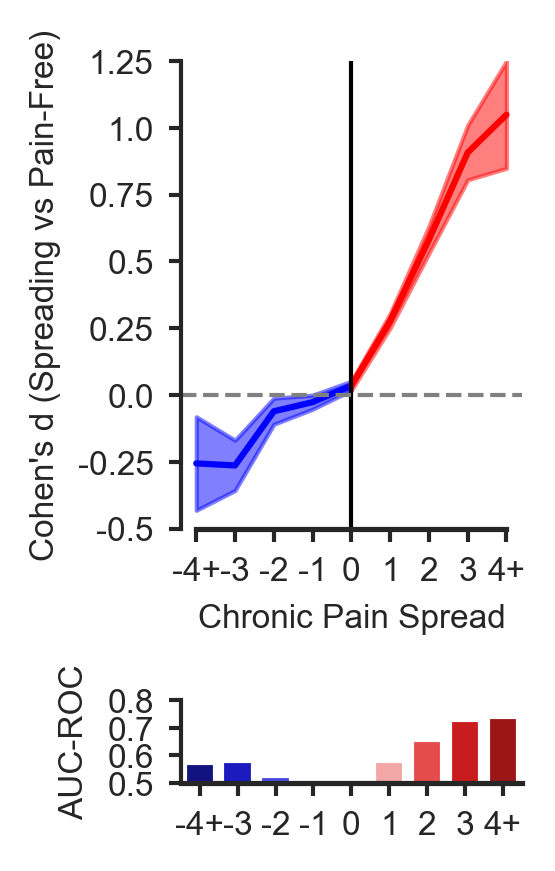

In [21]:
#### FIGURE C1. Effect Sizes across Levels of Spreading ####
fig, axs = plt.subplots(ncols=1, nrows=2,  figsize=(2, 3), gridspec_kw={'width_ratios': [1], 'height_ratios': [0.85, 0.15]})
# Cohen's D
for i,c in zip([0,4], ['Blue', 'Red']): 
    i2, xlabels = i+5, np.arange(-4,5,1)
    axs[0].fill_between(xlabels[i:i2], Cohen_D.Low[i:i2], Cohen_D.High[i:i2], color = c, alpha = 0.5)
    axs[0].plot(xlabels[i:i2], Cohen_D['Estimate'][i:i2], color = c)
axs[0].axvline(x = 0, ls = '-', color = 'black', lw = 1), axs[0].axhline(y = 0, ls = '--', color = 'grey', lw = 1)
axs[0].set_ylim((-0.5, 1.25)), axs[0].set_yticks(np.arange(-0.5, 1.5, 0.25)), axs[0].set_yticklabels(np.arange(-0.5, 1.5, 0.25), fontsize = fs)
axs[0].set_xticks(np.arange(-4,5,1))
axs[0].set_ylabel("Cohen's d (Spreading vs Pain-Free)", fontsize = fs), axs[0].set_xlabel('Chronic Pain Spread', fontsize = fs)
axs[0].spines['bottom'].set_bounds((-4,4)), axs[0].spines['left'].set_bounds((-0.5,1.25))
# AUC-ROC
sns.barplot(ax = axs[1], data = AUC_ROC, palette = sns.color_palette("seismic", 9))
axs[1].set_ylim((0.5, 0.8)), axs[1].set_ylabel('AUC-ROC', fontsize = fs)
axs[1].set_yticks([0.50, 0.60, 0.70, 0.80]), axs[1].set_yticklabels([0.50, 0.60, 0.70, 0.80], fontsize = fs),
for i in range(2):
    axs[i].set_xticklabels(Change, fontsize = fs)
    axs[i].tick_params(left=True, bottom=True, length=3, width=1), axs[i].spines[['top', 'right']].set_visible(False)
    axs[i].spines[['top', 'left']].set_linewidth(1)
fig.tight_layout()

In [22]:
# Load biological variables
#Genetic and Brain
PRS = pd.read_csv(Folder + 'PRSice.PRS.csv').rename(columns = {'IID' : 'eid'})
ToPS = pd.read_csv(Folder + 'ToPS_NoLP_double.csv')
UKB_T2['Log_CRP_T0'] = np.log(UKB_T2.CRP_T0)
UKB_T2 = UKB_T2.merge(PRS[['PRS_5e-2', 'eid']], on = 'eid', how = 'left')
UKB_T2 = UKB_T2.merge(ToPS[['ToPS', 'eid']], on = 'eid', how = 'left') #Already cleaned and deconfounded

In [23]:
# Adjusting the Category Variables
conf = ['NCPS_T0', 'NCPS2_T0', 'Change_Age', 'Age_T0']  #Confounders
categories = variables.Category.unique()
for var in categories:
    df_TMP = variables[variables.Category==var]
    UKB_T2[var] = np.dot(UKB_T2[df_TMP['Name'] + '_T0'], df_TMP['weights'])
    reg_conf = lr.fit(UKB_T2[conf], UKB_T2[var]).predict(UKB_T2[conf])
    z_val =  stats.zscore(UKB_T2[var] - reg_conf, nan_policy='omit')
    UKB_B[var + '_Res'], UKB_T2[var + '_Res'] = z_val, z_val

In [24]:
# Adjusting the Biological Variables
bio_var, bio_var2 = ['Log_CRP_T0', 'PRS_5e-2', 'ToPS'], ['CRP_Res', 'PRS_Res', 'ToPS_Res']
for var, var2 in zip(bio_var, bio_var2):
    F_TMP = UKB_T2[var].notna()
    reg_conf = lr.fit(UKB_T2[F_TMP][conf], UKB_T2[F_TMP][var]).predict(UKB_T2[conf])
    z_val =  stats.zscore(UKB_T2[var] - reg_conf, nan_policy='omit')
    UKB_B[var2], UKB_T2[var2] = z_val, z_val

In [25]:
# For Loop to Compute Cohen's d across levels of spreading
bio_var2 = ['CRP_Res', 'PRS_Res', 'ToPS_Res']
F_CPF =  (UKB_B.NCPS_T2==0) & (UKB_T2.NCPS_T0==0)
Cohen_Bio, Pval_Bio, Cohen_Cat, Pval_Cat = np.zeros((9,3)), np.zeros((9,3)), np.zeros((9,10)), np.zeros((9,10))
LVL = np.arange(-4,5,1)
for i in range(9):
    Group = UKB_T2[(UKB_T2.ChronicSpread == LVL[i]) & (~F_CPF)]
    Else = UKB_T2[F_CPF]
    for b in range(3):
        Cohen_Bio[i,b] = cohen_d(Group[bio_var2[b]], Else[bio_var2[b]])
        Pval_Bio[i,b] = stats.ttest_ind(Group[bio_var2[b]], Else[bio_var2[b]], nan_policy = 'omit')[1]
    for j in range(10): 
        Cohen_Cat[i, j] = cohen_d(Group[categories[j] + '_Res'], Else[categories[j] + '_Res'])
        Pval_Cat[i,j] = stats.ttest_ind(Group[categories[j] + '_Res'], Else[categories[j] + '_Res'])[1]

In [26]:
# Stack Bio and Cat, init = initial
Cohen_Mat_init = pd.DataFrame(data = np.hstack((Cohen_Cat, Cohen_Bio)), index  = Change, columns = categories.tolist() + ['C-Reactive Protein', 'Polygenic Risk Score', '* Tonic Pain Signature'])
Pval_Mat = np.hstack((Pval_Cat, Pval_Bio))

In [27]:
p_corr = nltools.stats.fdr(np.matrix.flatten(Pval_Mat), q = 0.05)
col, idx = pd.Series(categories.tolist() + ['C-Reactive Protein', 'Polygenic Risk Score', '* Tonic Pain Signature'], name = 'Adjusted Baseline Scores'), pd.Series(Change, name = 'Chronic Pain Spread at Follow-Up')
Cohen_Mat_corr = pd.DataFrame(data = np.where(Pval_Mat < 0.05, 1, 0) * Cohen_Mat_init, columns = col, index = idx)
sorted_idx = abs(Cohen_Mat_corr).mean().sort_values(ascending = False).index
Cohen_Mat_corr_sorted = Cohen_Mat_corr[sorted_idx]
Cohen_Mat_final = Cohen_Mat_corr_sorted.T[Cohen_Mat_corr_sorted.T.columns[::-1]].T
Cohen_Mat_final

Adjusted Baseline Scores,Mood,Anthropometric,Neuroticism,Sleep,Socioeconomic,Polygenic Risk Score,Traumas,SubstanceUse,C-Reactive Protein,PhysicalActivity,Demographics,* Tonic Pain Signature,Occupational
Chronic Pain Spread at Follow-Up,,,,,,,,,,,,,
4+,0.819105,0.453687,0.590444,0.538111,0.472444,0.384972,0.264201,0.403939,0.254596,0.230746,0.204887,0.330597,-0.000000
3,0.635195,0.489041,0.468389,0.463086,0.301807,0.277154,0.338975,0.257432,0.252417,0.278994,0.272429,0.000000,0.000000
2,0.435015,0.299013,0.369256,0.294145,0.185520,0.201778,0.138216,0.163763,0.174339,0.158992,0.135483,0.119571,0.088753
1,0.198033,0.166093,0.160961,0.130730,0.127768,0.123865,0.100222,0.062715,0.073690,0.028755,0.029555,0.041840,0.067734
0,0.152311,0.106540,0.094358,0.130819,0.071234,0.076171,0.039636,0.039635,0.049490,0.035888,0.000000,0.000000,0.000000
-1,-0.025449,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.025948,0.000000,-0.000000,-0.028313,0.000000,-0.000000
-2,-0.048004,-0.000000,0.000000,-0.000000,-0.051746,0.000000,-0.000000,-0.049165,-0.000000,-0.069933,0.000000,-0.054904,0.000000
-3,-0.209038,-0.169334,-0.088750,-0.000000,-0.097559,-0.000000,-0.173578,-0.000000,-0.103329,-0.092287,-0.000000,-0.000000,-0.000000
-4+,-0.198269,-0.151645,-0.000000,-0.211359,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000


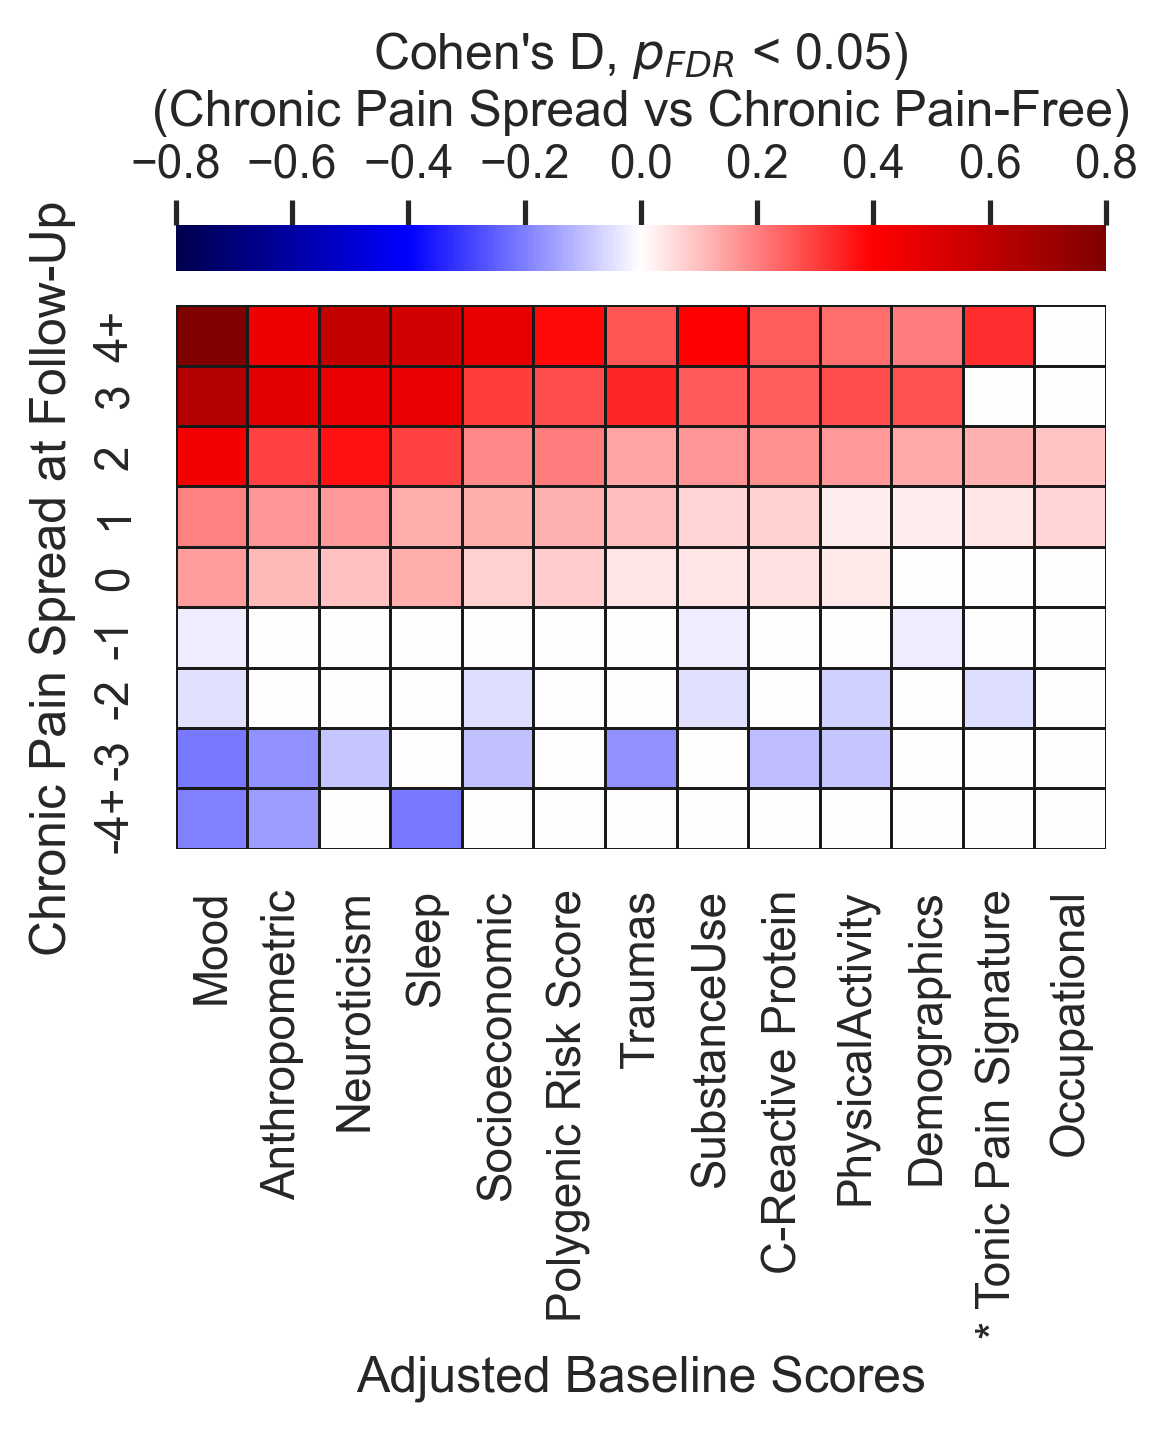

In [28]:
#### FIGURE C2. Adjusted Categories and Markers Longitudinally ####
fig, axs = plt.subplots(ncols=1, nrows=1,  figsize=(4, 3))
sns.heatmap(ax = axs, data = Cohen_Mat_final, center = 0, vmax = 0.8, vmin = -0.8, cmap = "seismic", linecolor='k', linewidths=.25, cbar_kws =  {'ticks':[-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8], 'label': "Cohen's D, $p_{FDR}$ < 0.05)" + '\n(Chronic Pain Spread vs Chronic Pain-Free)', 'use_gridspec': False, 'location': 'top'})
axs.tick_params(left=False, bottom=False)

In [38]:
#### Extra Figure to Compute the AUC-ROC across Non-Cancer Illnesses
NCI = pd.read_csv(Folder + '1_UKB_NonCancer_Illness.csv')
Coding_NCI = pd.read_csv(Folder + 'coding6.tsv', sep = '\t')
Coding_NCI = Coding_NCI[(Coding_NCI.coding!=-1) & (Coding_NCI.coding!=99999)]
Z_T0 = ['NCI_Free_T0', 'NCI_cervical spondylosis_T0', 'NCI_spine arthritis/spondylitis_T0','NCI_disc degeneration_T0', 'NCI_fibromyalgia_T0','NCI_spinal injury_T0', 'NCI_headaches (not migraine)_T0', 'NCI_irritable bowel syndrome_T0','NCI_osteoarthritis_T0', 'NCI_migraine_T0','NCI_rheumatoid arthritis_T0', 'NCI_emphysema/chronic bronchitis_T0', 'NCI_trapped nerve/compressed nerve_T0','NCI_chronic fatigue syndrome_T0','NCI_gastric/stomach ulcers_T0','NCI_hiatus hernia_T0','NCI_endometriosis_T0','NCI_chronic obstructive airways disease/copd_T0', 'NCI_angina_T0','NCI_gastro-oesophageal reflux (gord) / gastric reflux_T0','NCI_carpal tunnel syndrome_T0', 'NCI_pulmonary embolism +/- dvt_T0', 'NCI_stroke_T0','NCI_heart attack/myocardial infarction_T0','NCI_diabetes_T0','NCI_multiple sclerosis_T0']
Z2 = ['Free','Cervical Spondylosis','Spinal Spondylitis','Disc Degeneration','Fibromyalgia','Spinal Injury','Non-Migraine Headaches','Irritable Bowel Synd.','Osteoarthritis','Migraine','Rheumatoid Arthritis','Chronic Bronchitis','Compressed Nerve','Chronic Fatigue Synd.','Gastric Ulcers','Hiatus Hernia','Endometriosis','Chronic Obstructive\nPulmonary Disease','Angina','Gastro-Oesophageal\nReflux','Carpal Tunnel Synd.','Pulmonary Embolism ','Stroke','Myocardial Infarction','Diabetes','Multiple Sclerosis']
Z1, Z_T2 = [i[:-3] for i in Z1], [i[:-3] + '_T2' for i in Z1]

In [50]:
#NCIs 
NCI_T2, NCI_B = NCI[NCI.eid.isin(list_eid)].sort_values(by = 'eid').reset_index(drop = True).filter(like = 'T0'), NCI[NCI.eid.isin(list_eid)].sort_values(by = 'eid').reset_index(drop = True).filter(like = 'T2')
NCI_T2, NCI_B = pd.DataFrame(data = np.where(NCI_T2 > 0, 1, NCI_T2), columns = NCI_T2.columns), pd.DataFrame(data = np.where(NCI_B > 0, 1, NCI_B), columns = NCI_B.columns)
NCI_T2['NCI_Free_T0'], NCI_B['NCI_Free_T2'] = np.where(NCI_T2.sum(axis = 1) > 0, 0, 1), np.where(NCI_B.sum(axis = 1) > 0, 0, 1)
NCI_T2['eid'], NCI_B['eid'] = list_eid, list_eid
NCI_T2, NCI_B = NCI_T2[Z_T0 + ['eid']].merge(UKB_T2[['eid', 'PLS_res']], on = 'eid'), NCI_B[Z_T2 + ['eid']].merge(UKB_T2[['eid', 'PLS_res']], on = 'eid')
NCI_T = (NCI_B[Z_T2] - NCI_T2[Z_T0].values).rename(dict(zip(Z_T2, Z2)))
NCI_T['PLS_res'] = NCI_T2['PLS_res']

In [56]:
#Done with 1,000 resample to reduce time
W_pval, W_d, W_up, W_dn = [], [], [], []
R_pval, R_d, R_up, R_dn = [], [], [], []

rng = np.random.default_rng()
for i in Z1:
    #Worsen
    i[:3]
    W_DF = NCI_B[NCI_T2[i + '_T0'] == 0]
    W1, W2 = W_DF[W_DF[i + '_T2']==1].PLS_res, W_DF[W_DF[i + '_T2']==0].PLS_res
    W_BS = stats.bootstrap((W1, W2), cohen_d, confidence_level=0.95,method='percentile',random_state=rng,n_resamples=1000,vectorized=False)
    W_d.append(cohen_d(W1,W2)), W_dn.append(W_BS.confidence_interval[0]), W_up.append(W_BS.confidence_interval[1])

    #Recover
    R_DF = NCI_B[NCI_T2[i + '_T0'] == 1]
    R1, R2 = R_DF[R_DF[i + '_T2']==1].PLS_res, R_DF[R_DF[i + '_T2']==0].PLS_res
    R_BS = stats.bootstrap((R1, R2), cohen_d, confidence_level=0.95,method='percentile',random_state=rng,n_resamples=1000,vectorized=False)
    R_d.append(cohen_d(R1,R2)), R_dn.append(R_BS.confidence_interval[0]), R_up.append(R_BS.confidence_interval[1])



W = pd.DataFrame({'Up': W_up, 'Low': W_dn, 'D': W_d}, index = Z2).drop(index = 'Free').sort_values(by = 'D', ascending = False)
R = pd.DataFrame({'Up': R_up, 'Low': R_dn, 'D': R_d}, index = Z2).drop(index = 'Free').T[W.index].T


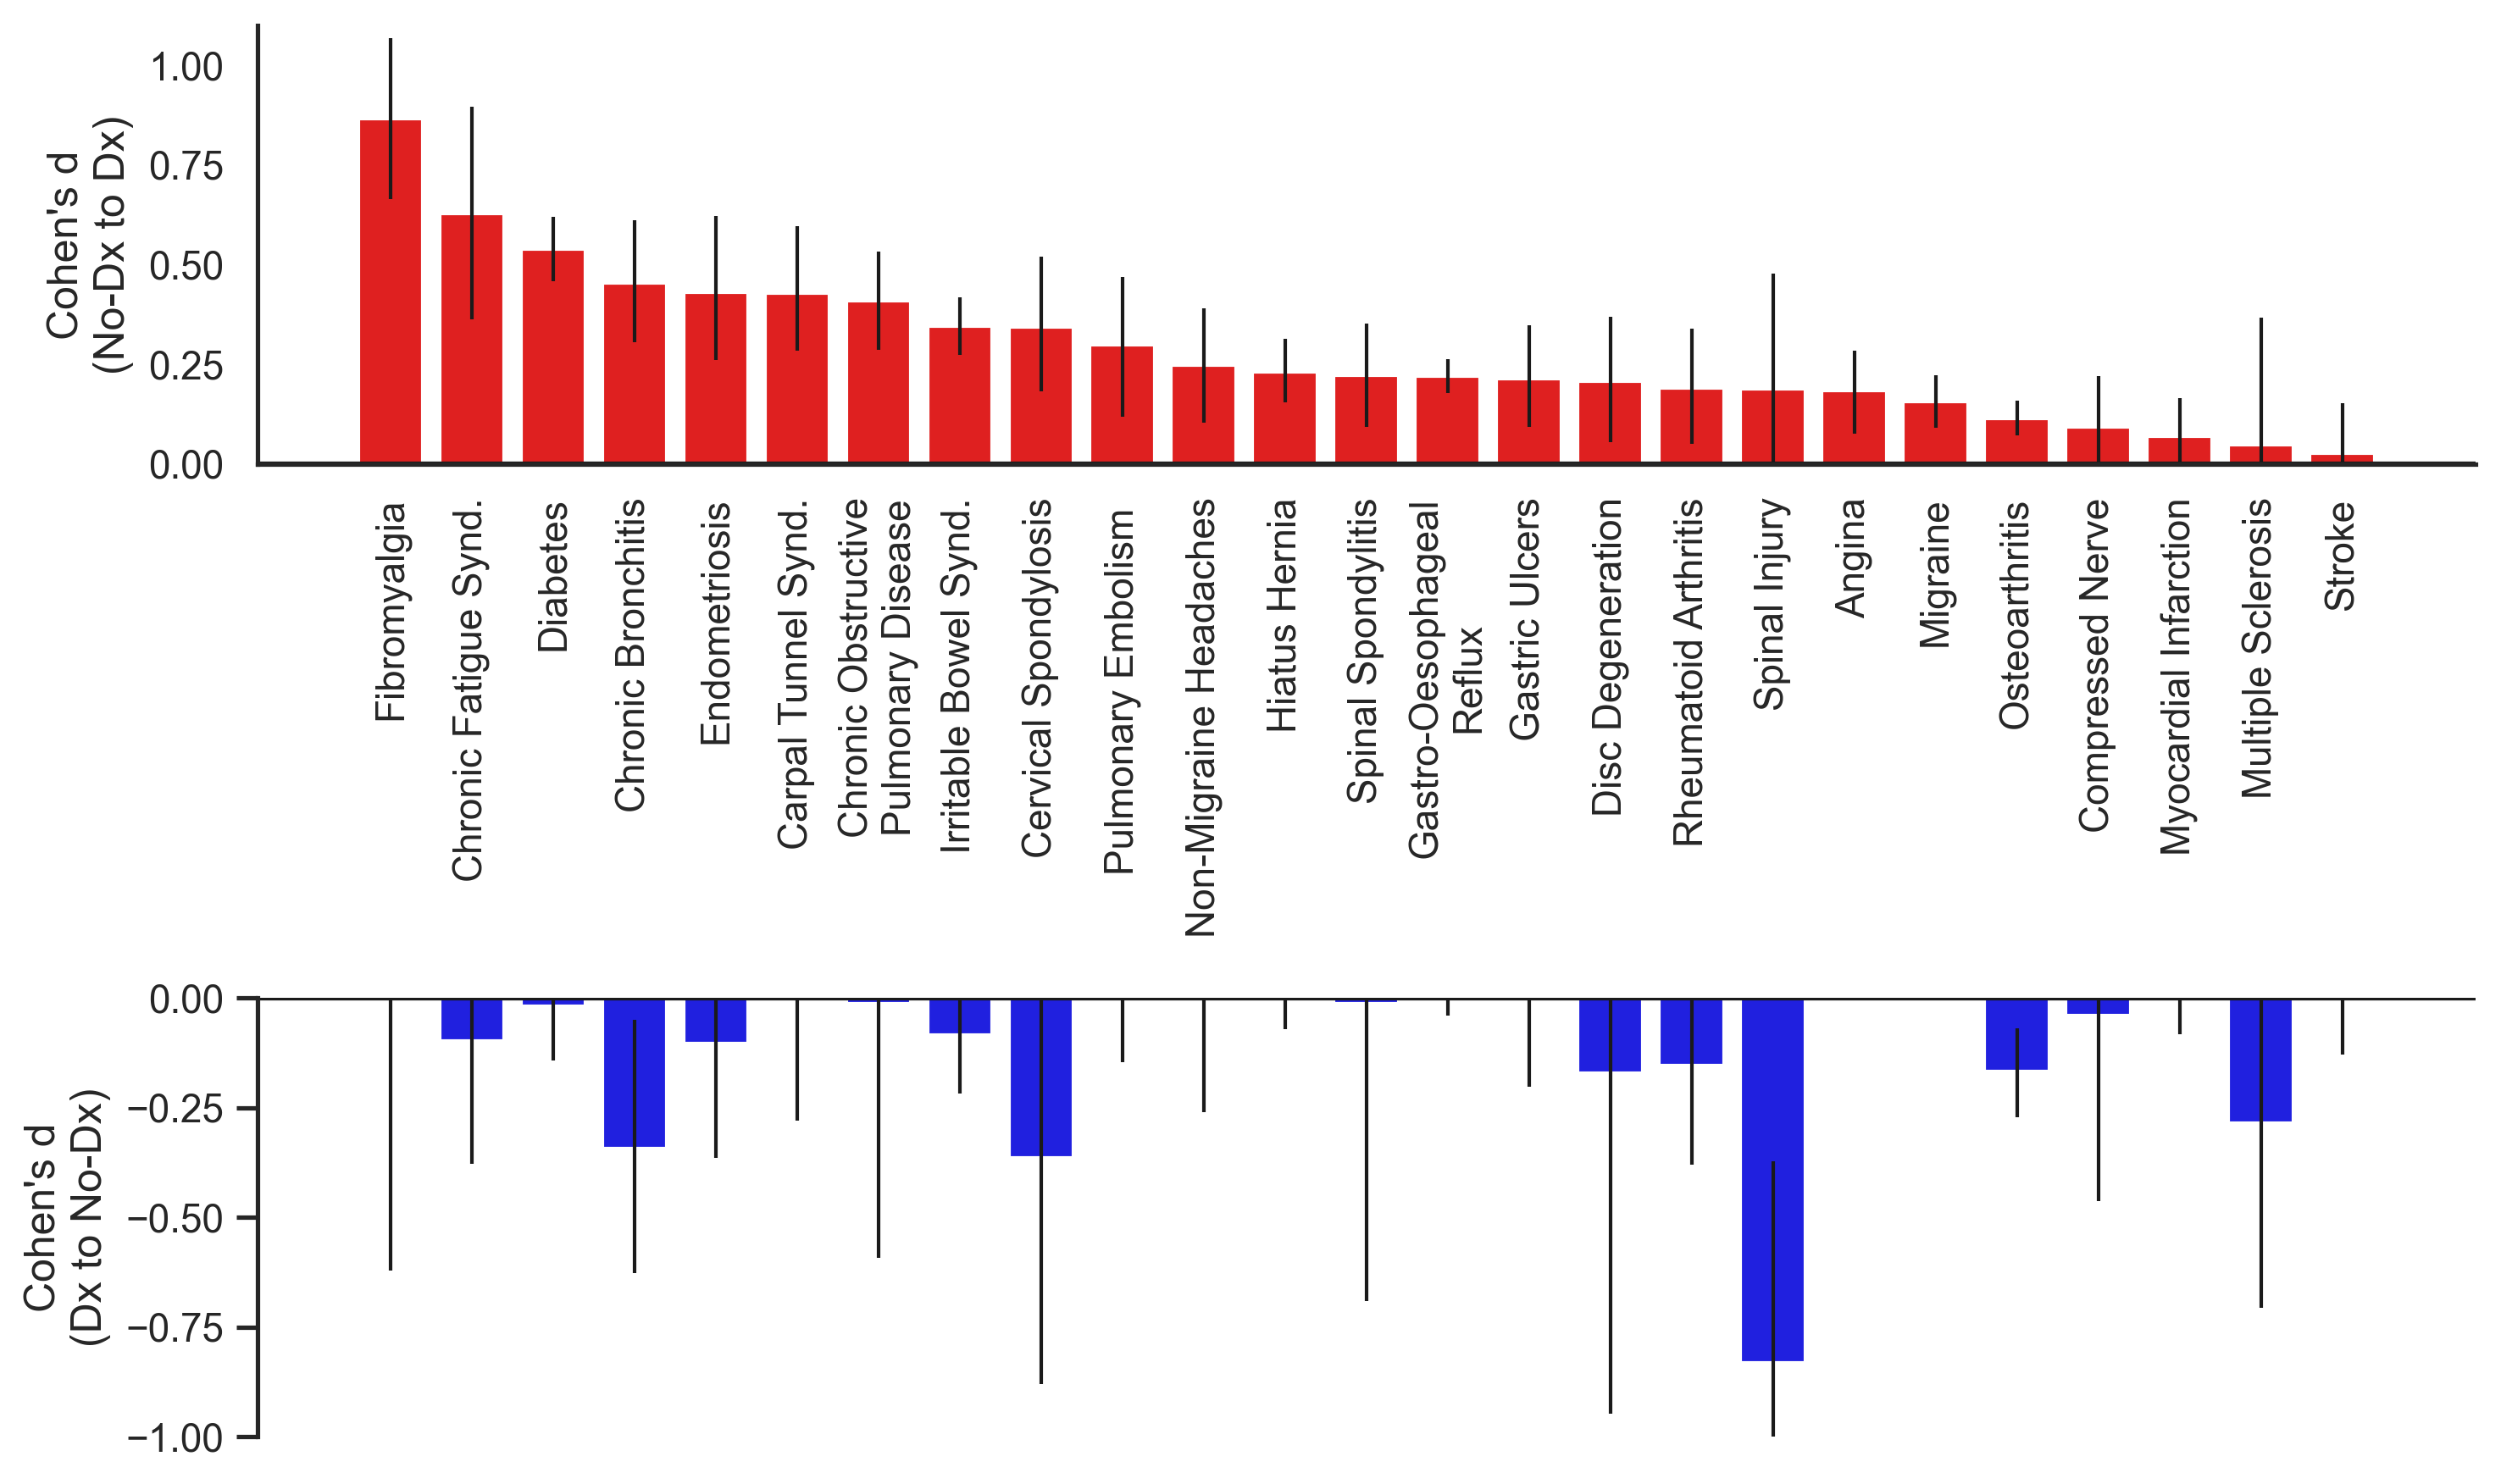

In [61]:
### Plot the AUC-ROC
fig, axs = plt.subplots(ncols=1, nrows=2,  figsize=(10, 6))
# Barplots
sns.barplot(ax = axs[0], y = W['D'], x = W.index, color = 'red')
sns.barplot(ax = axs[1], y = -R['D'], x = W.index, color = 'blue')
axs[0].errorbar(x = np.arange(0,25), y = W.D, yerr = [(W.D - W.Low), (W.Up - W.D)], fmt="", linestyle="", ecolor = 'k', elinewidth = 1)
axs[1].errorbar(x = np.arange(0,25), y = -R.D, yerr = [(-R.D + R.Low), (-R.Up + R.D)], fmt="", linestyle="", ecolor = 'k', elinewidth = 1)
# Figure details
axs[0].axhline(y = 0, ls = '-', color = 'k'), axs[1].axhline(y = 0, ls = '-', color = 'k')
axs[0].spines[['top', 'right']].set_visible(False), axs[1].spines[['top', 'right', 'bottom']].set_visible(False)
axs[0].set_ylim((0, 1.1)), axs[1].set_ylim((-0.5, 0))
axs[0].set_yticks(np.arange(0, 1.25, 0.25)), axs[1].set_yticks(np.arange(-1, 0.25, 0.25))
axs[0].set_xticklabels(W.index, rotation = 90, ha="center"), axs[1].set_xticklabels([])
axs[1].tick_params(left=True, bottom=False)
axs[0].set_ylabel("Cohen's d\n(No-Dx to Dx)"), axs[1].set_ylabel("Cohen's d\n(Dx to No-Dx)")
fig.tight_layout()